# This notebook talke the raw output from Hamiltonian Replica Exchange, extract the dihedral angle from xtc file using MdTraj, and ananlyze the autocoorelation curve

In [6]:
import os, sys, glob, shutil, re
import subprocess

import mdtraj as md
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import math
from IPython.display import Image, display
%matplotlib inline
nmer = 5
mpl.rcParams.update({'font.size': 16})

In [2]:
%pwd

'/Users/starwingchen/Voelz_Lab/git/peptoid_24summer/peptoid/19AF1-10-A/GAFF/protonated/HREX_500ns'

In [4]:
import os
import subprocess

# Loop through each directory in the current working directory
for state_dir in os.listdir('.'):
    if os.path.isdir(state_dir) and state_dir.startswith('state_'):

        input_gro = os.path.join(state_dir, 'HREMD.part0001.gro')
        output_gro = os.path.join(state_dir, 'HREMD_withoutwater.part0001.gro')
        command = f'echo "40\nq\n" | gmx editconf -f {input_gro} -n index.ndx -o {output_gro}'
        
        # Run the GROMACS command
        try:
            subprocess.run(command, shell=True, check=True)
            print(f"Processed {input_gro}")
        except subprocess.CalledProcessError as e:
            print(f"Failed to process {input_gro}: {e}")
       
        # Remove all files with # in their names
        rm_command = f'rm -f {os.path.join(state_dir, "#*")}'
        try:
            subprocess.run(rm_command, shell=True, check=True)
            print(f"Removed # files in {state_dir}")
        except subprocess.CalledProcessError as e:
            print(f"Failed to remove # files in {state_dir}: {e}")

                     :-) GROMACS - gmx editconf, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
    

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 16133 atoms
Volume: 163.21 nm^3, corresponds to roughly 73400 electrons
Velocities found
Selected 40: 'peptoid'
Processed state_3/HREMD.part0001.gro
Removed # files in state_3
Note that major changes are planned in future for editconf, to improve usability and utility.
Read 16133 atoms
Volume: 162.518 nm^3, corresponds to roughly 73100 electrons
Velocities found
Selected 40: 'peptoid'
Processed state_4/HREMD.part0001.gro
Removed # files in state_4
Note that major changes are planned in future for editconf, to improve usability and utility.
Read 16133 atoms
Volume: 163.107 nm^3, corresponds to roughly 73300 electrons
Velocities found
Selected 40: 'peptoid'
Processed state_5/HREMD.part0001.gro
Removed # files in state_5
Note that major changes are planned in future for editconf, to improve usability and utility.
Read 16133 atoms
Volume: 163.709 nm^3, corresponds to roughly 73600 electrons
V

                     :-) GROMACS - gmx editconf, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
    

In [5]:
# Define the directory path
directory = "omega_data/"

# Check if the directory exists
if os.path.exists(directory):
    # Remove all contents of the directory
    shutil.rmtree(directory)
    # Recreate the empty directory
    os.makedirs(directory)
    print(f"All contents in '{directory}' have been cleared.")
else:
    # Create the directory if it does not exist
    os.makedirs(directory)
    print(f"Directory '{directory}' did not exist, so it has been created.")


Directory 'omega_data/' did not exist, so it has been created.


In [18]:
# Search the dihedral index 
pattern = r' CA-     C-     N-    CA' # Backbone dihedral we want 
gmx_dihedral_indices = []

with open('19AF1-10-A_fep.itp', 'r') as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            parts = line.strip().split()
            dihedral = parts[:4] # Extract the dihedral index 
            if dihedral not in gmx_dihedral_indices:
                gmx_dihedral_indices.append(dihedral)

gmx_dihedral_indices = np.array(gmx_dihedral_indices, dtype=int)
print(gmx_dihedral_indices)
print(f"gmx_dihedral_indices.shape : {gmx_dihedral_indices.shape}")

[[ 12  13  27  38]
 [ 38  39  60  70]
 [ 70  71  86 101]
 [101 102 127 138]
 [138 139 152 162]
 [162 163 186 194]
 [194 195 206 213]
 [213 214 231 240]
 [240 241 252 263]]
gmx_dihedral_indices.shape : (9, 4)


In [19]:
# Define omega dihedral indices, gromcas start from 1, while np start from 0
omega_dihedral_indices = gmx_dihedral_indices - 1
print(omega_dihedral_indices)

# Ensure the omega_data directory exists
omega_path = 'omega_data/'
if not os.path.exists(omega_path):
    os.makedirs(omega_path)

# Calculate omegas for each state
for state in range(6):
    xtcfile = f"state_{state}/HREMD.part0001.xtc"
    grofile = f"state_{state}/HREMD_withoutwater.part0001.gro"
    traj = md.load(xtcfile, top=grofile)
    omegas = md.compute_dihedrals(traj, omega_dihedral_indices) * (180.0 / math.pi)

    # Save omegas
    outfile = os.path.join(omega_path, f"omegas_state{state}.npy")
    np.save(outfile, omegas)
    print(f"Saved omegas for state {state} to {outfile}")

[[ 11  12  26  37]
 [ 37  38  59  69]
 [ 69  70  85 100]
 [100 101 126 137]
 [137 138 151 161]
 [161 162 185 193]
 [193 194 205 212]
 [212 213 230 239]
 [239 240 251 262]]
Saved omegas for state 0 to omega_data/omegas_state0.npy
Saved omegas for state 1 to omega_data/omegas_state1.npy
Saved omegas for state 2 to omega_data/omegas_state2.npy
Saved omegas for state 3 to omega_data/omegas_state3.npy
Saved omegas for state 4 to omega_data/omegas_state4.npy
Saved omegas for state 5 to omega_data/omegas_state5.npy


In [20]:
print(np.load('omega_data/omegas_state0.npy')[:5])

[[-131.94534 -164.36684 -168.73222  164.69473  170.56618 -178.08678
   155.54361  169.69421 -178.63116]
 [-167.8904  -177.17209  162.46188  167.34125  178.12256  156.80368
   149.18318 -159.73303 -144.3094 ]
 [-129.7263  -171.66838  173.76761 -176.36858 -168.82204 -160.51863
   152.26566  169.96507 -172.13924]
 [-161.32402 -169.03375 -177.91661 -150.35559  177.52377 -164.51442
  -178.33974  170.00888  149.8075 ]
 [-167.7076   179.63324 -152.12892 -154.57758  167.17616 -168.40686
   169.82945  174.13362 -159.3424 ]]


### What is the time interval between `*.xtc` snapshots?

In [21]:
%cat prod_fep.mdp | grep nstxout-compressed

nstxout-compressed      = 5000      ; save compressed coordinates every 10.0 ps


In [22]:
dt_in_ns = 0.010   #  ns

### What are the dimensions of the omega-angle arrays in each Hamiltonian state? 

In [23]:
nstates = 6

for i in range(nstates):
    omegas = np.load(f"omega_data/omegas_state{i}.npy")
    print(f'state {i}:, {omegas.shape}')

state 0:, (30001, 9)
state 1:, (30001, 9)
state 2:, (30001, 9)
state 3:, (30001, 9)
state 4:, (30001, 9)
state 5:, (30001, 9)


In [24]:
current_state = [0, 1, 2, 3, 4, 5]
logfile = 'state_0/HREMD.part0001.log'
pattern = 'Repl ex'
output_file = 'replica_indices.dat'

states = []
states.append( current_state.copy() ) # Make a copy of initial_state

# DEbug:  Let's see if xtc is written BEFORE swap 
states.append( current_state.copy() ) # Make a copy of initial_state

VERBOSE = False

try:

    with open(logfile, 'r') as file:
        lines = file.readlines()

        for line in lines:
            if pattern in line:
                parts = line.strip().split()
                if VERBOSE:
                    print(f'parts: {parts}')
                for i in range(2, len(parts)):
                    if 'x' in parts[i]:
                        index1 = int(parts[i-1])
                        index2 = int(parts[i+1])
                        
                        # Swap the positions in the current state
                        tmp1, tmp2 = current_state[index1], current_state[index2]
                        current_state[index1] = tmp2
                        current_state[index2] = tmp1
                states.append( current_state.copy() )  # Append a copy of the last state
    
    # DEbug:  Let's see if xtc is written BEFORE swap 
    if (0): 
        # for the last frame
        states.append( current_state.copy() )  # Append a copy of the state (last frame doesn't swap)

                
    # Write states to output_file
    with open(output_file, 'w') as outfile:
        for state in states:
            outfile.write(' '.join(map(str, state)) + '\n')

    print(f"Output saved to {output_file}")


except FileNotFoundError:
    print(f"The file {logfile} does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

Output saved to replica_indices.dat


In [26]:
all_omegas = [] # Load in the omega values for all replicas
for state in range(6):  # Adjust the range to include all replicas
    all_omegas.append(np.load(f"omega_data/omegas_state{state}.npy"))
all_omegas = np.array(all_omegas)  # (nreps, nsnaps, nresidues)
print('all_omegas.shape', all_omegas.shape)
#print(all_omegas[:5])

# Arrange each snapshot by replica (not temp)
replica_indices = np.loadtxt('replica_indices.dat')
print("replica_indices.shape", replica_indices.shape)
#print(replica_indices)

all_omegas_by_replica = np.zeros(all_omegas.shape)

start = 0
nsnaps = 30000
nreps = 6
for i in range(nsnaps):
    Ind = np.argsort(replica_indices[i, :])
    all_omegas_by_replica[:, i, :] = all_omegas[Ind, i, :]

# Save the data for each state once
for rep in range(nreps):
    np.save(f"omega_data/omegas_rep{rep}.npy", all_omegas_by_replica[rep, :, :])
    print(f"Saved omegas for replica {rep} to omega_data/omegas_rep{rep}.npy")
    #print(np.load(f'omega_data/omegas_rep{rep}.npy')[:5])

all_omegas.shape (6, 30001, 9)
replica_indices.shape (30001, 6)
Saved omegas for replica 0 to omega_data/omegas_rep0.npy
Saved omegas for replica 1 to omega_data/omegas_rep1.npy
Saved omegas for replica 2 to omega_data/omegas_rep2.npy
Saved omegas for replica 3 to omega_data/omegas_rep3.npy
Saved omegas for replica 4 to omega_data/omegas_rep4.npy
Saved omegas for replica 5 to omega_data/omegas_rep5.npy


In [37]:
# Adjust omega values into the range (-90, 270)
all_omegas_by_replica = (all_omegas_by_replica + 90.0) % 360.0 - 90.0

start = 0
nsnaps = 30000
nreps = 6
residues_to_plot = [0, 1, 2, 3, 4, 5, 6, 7, 8]
num_residues = len(residues_to_plot)

ShowPlots = False

# Plot omega angles vs time for selected residues for each replica
for i in range(nreps):
    plt.figure(figsize=(30, 100))
    for panel, residue in enumerate(residues_to_plot, 1):
        plt.subplot(num_residues, 1, panel)
        t = np.arange(start, nsnaps) * 0.010  # Time axis in ns
        plt.plot(t, all_omegas_by_replica[i, start:nsnaps, residue], '.', ms=4)
        plt.xlabel('time (ns)')
        plt.ylabel(f'$\\omega$ res {residue} (deg)')
        plt.title(f'Omega angles vs Time for residue {residue} (replica {i}) in 19AF1-10-A')
    #plt.tight_layout()
    if ShowPlots:
        plt.show()
    else:
        outfilename = f'omega_data/Omega_angles_vs_Time_residue_{residue}_Replica_{i}_in_19AF1-10-A.png'
        plt.savefig(outfilename)
        print(f"Saved at: {outfilename}")
        plt.clf()  # Clear the figure for the next set of plots

Saved at: omega_data/Omega_angles_vs_Time_residue_8_Replica_0_in_19AF1-10-A.png
Saved at: omega_data/Omega_angles_vs_Time_residue_8_Replica_1_in_19AF1-10-A.png
Saved at: omega_data/Omega_angles_vs_Time_residue_8_Replica_2_in_19AF1-10-A.png
Saved at: omega_data/Omega_angles_vs_Time_residue_8_Replica_3_in_19AF1-10-A.png
Saved at: omega_data/Omega_angles_vs_Time_residue_8_Replica_4_in_19AF1-10-A.png
Saved at: omega_data/Omega_angles_vs_Time_residue_8_Replica_5_in_19AF1-10-A.png


<Figure size 3000x10000 with 0 Axes>

<Figure size 3000x10000 with 0 Axes>

<Figure size 3000x10000 with 0 Axes>

<Figure size 3000x10000 with 0 Axes>

<Figure size 3000x10000 with 0 Axes>

<Figure size 3000x10000 with 0 Axes>

## Autocoorelation 

In [38]:
def autocorr(x):
    tau = x.size
    mu = x.mean()
    g = np.correlate(x, x, mode='full')[tau-1:]
    n = np.arange(tau,0,-1)
    return g/n

avg_autocorrel = [] 
for residue in range(9):
    all_autocorrel = []
    for replica in range(6):
        # Example calculation, replace with your actual calculation
        cis_trans = np.where(all_omegas[replica,:,residue] > 90.0, 1.0, 0.0)
        print(f"residue {residue}, replica {replica}, cis_trans: {cis_trans}")
        
        all_autocorrel.append(autocorr(cis_trans))
    
    avg_autocorrel.append(np.array(all_autocorrel).mean(axis=0))
    outfile = f'omega_data/omega_autocorrel_residue{residue}.npy'
    print(f"Saving {outfile} ...")
    np.save(outfile, avg_autocorrel[-1]) 


residue 0, replica 0, cis_trans: [0. 0. 0. ... 0. 0. 0.]
residue 0, replica 1, cis_trans: [0. 0. 1. ... 0. 0. 0.]
residue 0, replica 2, cis_trans: [0. 0. 0. ... 0. 0. 0.]
residue 0, replica 3, cis_trans: [0. 1. 0. ... 0. 0. 0.]
residue 0, replica 4, cis_trans: [0. 0. 0. ... 0. 0. 0.]
residue 0, replica 5, cis_trans: [0. 0. 0. ... 0. 0. 0.]
Saving omega_data/omega_autocorrel_residue0.npy ...
residue 1, replica 0, cis_trans: [0. 0. 0. ... 1. 1. 0.]
residue 1, replica 1, cis_trans: [0. 0. 0. ... 0. 1. 1.]
residue 1, replica 2, cis_trans: [0. 0. 0. ... 1. 1. 0.]
residue 1, replica 3, cis_trans: [0. 1. 1. ... 0. 0. 0.]
residue 1, replica 4, cis_trans: [0. 1. 0. ... 1. 0. 0.]
residue 1, replica 5, cis_trans: [0. 1. 1. ... 0. 0. 0.]
Saving omega_data/omega_autocorrel_residue1.npy ...
residue 2, replica 0, cis_trans: [0. 1. 1. ... 0. 0. 0.]
residue 2, replica 1, cis_trans: [0. 0. 1. ... 0. 0. 0.]
residue 2, replica 2, cis_trans: [0. 0. 0. ... 0. 0. 0.]
residue 2, replica 3, cis_trans: [0. 0. 1

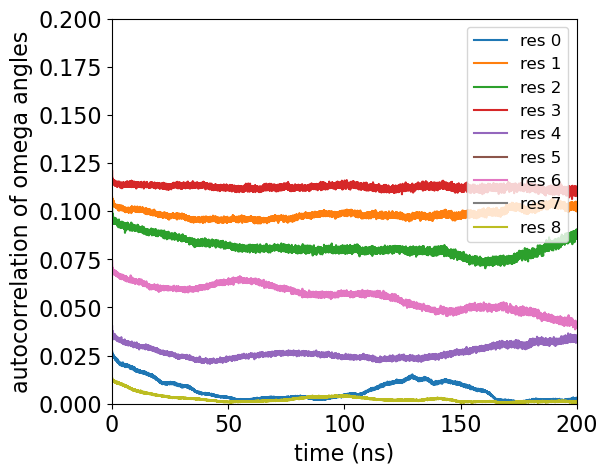

In [42]:
avg_autocorrels = []
plt.figure(figsize=(6,5))
t = np.arange(0, len(cis_trans))*0.010 # frames saved every 10 ps

for residue in range(0,9):   # the last residue
    infile = f'omega_data/omega_autocorrel_residue{residue}.npy'
    data = np.load(infile)
    avg_autocorrels.append(data)
    plt.plot(t, data, label='res %d'%residue)
    plt.xlim(0,200) # only show first part of the autocorrelation curves
    plt.ylim(0,0.2) # only show first part of the autocorrelation curves

plt.xlabel('time (ns)')
plt.ylabel('autocorrelation of omega angles')
plt.legend(loc='upper right', fontsize=12)

plt.show()

--- Residue 0 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: 0.010136432126531446 +/- 3.199704617761501e-09
Best-fit a1: 0.017729491951184784 +/- 3.7909228367294424e-07
Best-fit tau: 8.905303359448446 +/- 0.20443776723365245
--- Residue 1 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: 1996.7003915448392 +/- 101072201.5226091
Best-fit a1: -1996.6110429879714 +/- 101072202.21231335
Best-fit tau: 19129856.871372763 +/- 9278536697247186.0
--- Residue 2 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: 0.08483190993981429 +/- 2.02965469518997e-09
Best-fit a1: 0.013317327377419402 +/- 1.824858526781523e-07
Best-fit tau: 11.31357315493496 +/- 0.28706183791146284
--- Residue 3 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: -201.96904060576264 +/- 17412485.463805098
Best-fit a1: 202.08506826945913 +/- 17412485.42649219
Best-fit tau: 5429970.069411056 +/- 1.2572178354957888e+16
--- Residue 4 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: 0.034083585506752834 +/- 6

/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_91385/1626844270.py:7: RuntimeWarning: overflow encountered in exp
  return a0 + a1 * np.exp(-x / tau)


--- Residue 5 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: -110.3972350457981 +/- 140678603.13800898
Best-fit a1: 110.68571320976193 +/- 140678603.3434699
Best-fit tau: 2082401.2130157014 +/- 4.980071323619785e+16
--- Residue 6 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: 0.045809804298572454 +/- 3.299749644788766e-08
Best-fit a1: 0.022717299054026772 +/- 4.0623062701964565e-08
Best-fit tau: 95.82798694971538 +/- 6.604810985964185
--- Residue 7 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: 0.2569271218305795 +/- 1.3197599974976473e-07
Best-fit a1: -0.004840606141356288 +/- 1.0760019927739898e-07
Best-fit tau: 115.00594496741951 +/- 621.834514438489
--- Residue 8 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: 0.003831758470104678 +/- 1.4599096118206902e-09
Best-fit a1: 0.010215884911699797 +/- 2.1049782439071825e-07
Best-fit tau: 7.463658311935939 +/- 0.23839402920899003


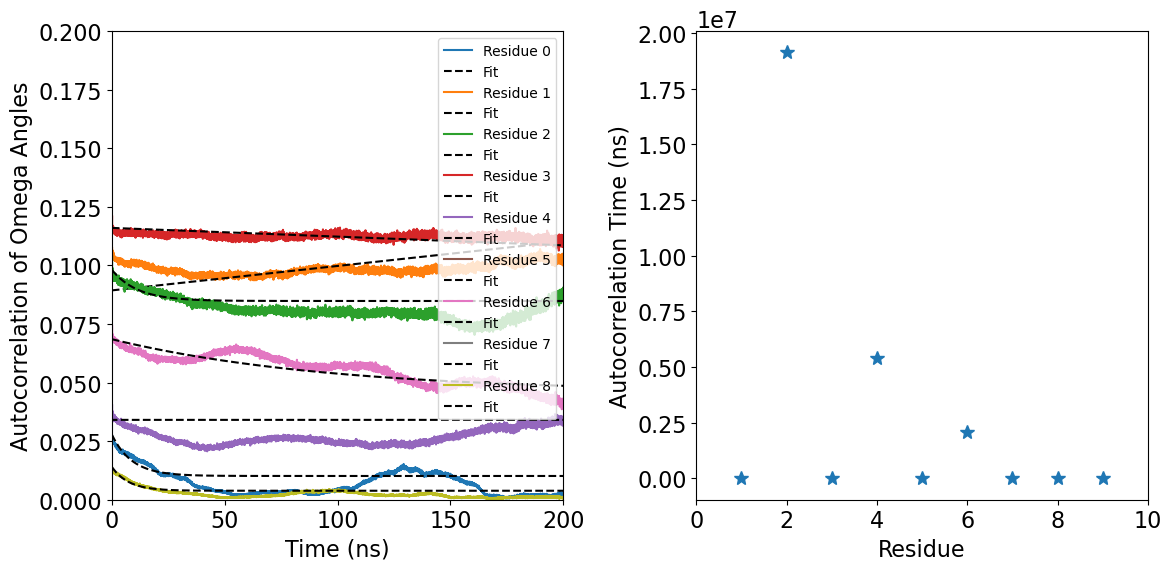

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Functional form for fitting
def single_exp_decay(x, a0, a1, tau):
    return a0 + a1 * np.exp(-x / tau)

# Fit each autocorrelation and plot results
fit_taus = []

plt.figure(figsize=(12, 6))

# Loop over each residue
for residue in range(9):
    
    # Initial guess for fitting parameters
    first_value = avg_autocorrels[residue][0]
    initial_guess = [first_value / 2.0, first_value / 2.0, 40.0]  # Initial guess [a0, a1, tau]
    
    # Perform curve fitting
    popt, pcov = curve_fit(single_exp_decay, t[:40000], avg_autocorrels[residue][:40000], p0=initial_guess)
    
    # Compute fitted curve
    y_fit = single_exp_decay(t[:40000], *popt)
    
    # Collect fitted tau values
    fit_taus.append(popt[2])
    
    # Print fit results
    print(f'--- Residue {residue} ---')
    print('### FIT to a0 + a1*exp(-(x/tau)) ###')
    print(f'Best-fit a0: {popt[0]} +/- {pcov[0][0]}')
    print(f'Best-fit a1: {popt[1]} +/- {pcov[1][1]}')
    print(f'Best-fit tau: {popt[2]} +/- {pcov[2][2]}')

    # Plot original data and fitted curve
    plt.subplot(1, 2, 1)
    plt.plot(t[:40000], avg_autocorrels[residue][:40000], label=f'Residue {residue}')
    plt.plot(t[:40000], y_fit, 'k--', label='Fit')
    plt.xlim(0, 200)
    plt.ylim(0, 0.2)
    plt.xlabel('Time (ns)')
    plt.ylabel('Autocorrelation of Omega Angles')
    plt.legend(loc='upper right', fontsize=10)
    
# Plotting the fitted tau values
plt.subplot(1, 2, 2)
plt.plot(range(1, 10), fit_taus, '*', markersize=10)
plt.xlim(0, 10)
plt.xlabel('Residue')
plt.ylabel('Autocorrelation Time (ns)')
plt.tight_layout()

plt.show()
